# Analysis of Brawl Stars Data Set

- Brawl Stars is a mobile online multiplayer battle game. A player choses a Brawler as game character and plays against other players or against AI opponents.
- Currently there exist 36 different Brawler. Each Brawler has a power level from 1 to 10. With the help of the in-game loot boxes those power levels can be upgraded.
- There exist several game modes, where you either play solo or in a team of 2 or 3 against other players or AI opponents.

# Preliminaries

- To process and clean the Brawl Stars Data Set we make use of python libraries which are designed for data processing.
- To collect the Brawl Stars Data Set a Brawl Stars API wrapper called brawlstats is used.

Import the default pyhton libraries for data processing.

In [1]:
import os, json
import random
import pandas as pd # for data stuff
import numpy as np # for importing data i think, not sure anymore
import matplotlib.pyplot as plt #for plotting

# the modules below are used in "Analys Models" section
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from pandas.io.json import json_normalize



Bad key "text.kerning_factor" on line 4 in
C:\Users\jerem\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Install brawlstats, a python wrapper to retrieve data from the Brawl Stars API
 - https://brawlstats.readthedocs.io/en/latest/index.html

In [2]:
!pip install brawlstats

# Data Collection

- We collect battlelogs from the Brawl Stars API.

Import brawlstats 

In [3]:
import brawlstats
import time

Establish connection to Brawl Stars API. A token resp. API Key is needed. Follow the steps below to obtain a token.
- create an account at: https://developer.brawlstars.com/#/
- get your IPv4 with: https://www.whatismyip.org/
- create an API Key on https://developer.brawlstars.com/#/ for your account and your API Key
- save your API key in this directory in a file named: token_brawlstats.txt
- run the cell below to establish the connection to the API

In [4]:
path = os.getcwd()
token_file =  open(os.path.join(path, "token_brawlstats.txt"), 'r')
token = token_file.read()
token_file.close()

client = brawlstats.Client(token)

- retrieve the top 200 players
- each player object contains a list of battle logs. Those battle logs contain meta data about the player's most recent played games. Those battlelogs form the raw data used for this project
- If we collect data from the API, the most recent battle logs will be retrieved. Therefore, we decided to store the retrieved data in "battlelog.json" such that we can continue with the same data every time this jupyter notebook is used. However, one could delete the current "battlelog.json" file in order to create a new data set from recently played games
- If you run the cell below a new data set is collected if no curent "battlelog.json" exists. However, if a new data set is collected, some adapations in this projects need to be made.

we assume the skill level of the top 200 players in the game is about the same. Therefore all retrieved battle logs are from players with a very high skill level, making the raw data more consistent and not depending on the skill level of a player


In [5]:
if not os.path.isfile("battlelogs.json"):
    
    # retrieve the player objects of the top 200 players
    tags_top_200_players = [player["tag"] for player in client.get_rankings(ranking='players', limit=200)]
    top_200_players = [client.get_player(tag) for tag in tags_top_200_players]
    
    # retrive their battlelogs with the corresponding player tag and stor it in "battlelogs.json" file
    with open("battlelogs.json", "w") as battlelog_file:
        for player in top_200_players:
            player_battlelogs = client.get_battle_logs(player.tag)
            for battlelog in player_battlelogs:
                battlelogs[index] = {}
                battlelogs[index]["player_tag"] = player.tag
                battlelogs[index]["battlelog"] = battlelog
                index += 1
        json.dump(battlelogs, battlelog_file)
        

# Data Cleaning

- some of the top players play against each other. Duplicates can be filtered since a battle log contains a unique key = "battle_time"

In [6]:
# read in the battlelogs.json file
with open("battlelogs.json",'r') as in_file:
    battlelogs = json.load(in_file)
    in_file.close()
    
# initialize list for unique battlelogs
unique_battlelogs = []
used_battle_times = []

# iterate over all battle logs
for key in battlelogs.keys():
    
    # get the battle time of the current battle log which is a unique key
    current_battle_time = battlelogs[key]['battlelog']["battle_time"]
    
    # append the current battle log if 
    # it is not already in the list of unique battle logs
    if not current_battle_time in used_battle_times:
        used_battle_times.append(current_battle_time)
        unique_battlelogs.append(battlelogs[key])

print("The total number of unique battle logs is: {}\n".format(len(unique_battlelogs)))
print("Below is a full battle log: ")    
print(json.dumps(unique_battlelogs[1], sort_keys=True, indent=4))
 
      

The total number of unique battle logs is: 4301

Below is a full battle log: 
{
    "battlelog": {
        "battle": {
            "duration": 143,
            "mode": "gemGrab",
            "result": "defeat",
            "star_player": {
                "brawler": {
                    "id": 16000013,
                    "name": "POCO",
                    "power": 10,
                    "trophies": 894
                },
                "name": "Lil,\u30c7\u30e1\u30eb\u26c4",
                "tag": "#YU2VVGLQ"
            },
            "teams": [
                [
                    {
                        "brawler": {
                            "id": 16000021,
                            "name": "GENE",
                            "power": 9,
                            "trophies": 1231
                        },
                        "name": "VestA\u2698\uc81c\ub85c",
                        "tag": "#8QRPGLQJJ"
                    },
                    {
                 

# Data Processing
- The Brawlers of the top players are analysed to see if they have most of their Brawlers on the max power level.

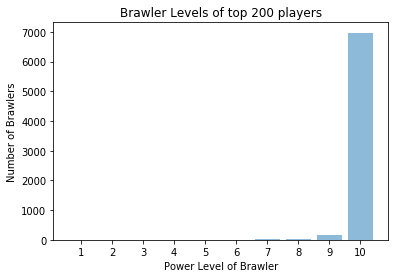

In [7]:
# retrieve the player objects of the top 200 players
tags_top_200_players = [player["tag"] for player in client.get_rankings(ranking='players', limit=200)]
top_200_players = [client.get_player(tag) for tag in tags_top_200_players]


# initialize brawler levels count to 0
# brawlers can be from level 1 to 10
brawler_levels = {}
for i in range(1, 11):
    brawler_levels[i] = 0
    
# loop over the top 200 players
for player in top_200_players:
    
    # loop over the brawlers of the current player
    for brawler in player.brawlers:
        # increment
        brawler_levels[brawler["power"]] += 1

# create a bar plot of the distribution of the brawler power levels
objects = brawler_levels.keys()
y_pos = np.arange(len(objects))
performance = brawler_levels.values()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel("Power Level of Brawler")
plt.ylabel('Number of Brawlers')
plt.title('Brawler Levels of top 200 players')

plt.show()

The plot clearly shows that the top 200 players have their brawler mostly on the max power level

# Bitte die zwei zelle chli schöner formatiere und dokumentiere, danke

In [8]:

### Retrieves information about the modes played and returns a dictionary with key:value (mode: counter)
modedict = {}
current_mode = ''
for log in unique_battlelogs:
    current_mode = log["battlelog"]["event"]["mode"]
    if current_mode not in modedict.keys():
        modedict[current_mode] = 0
    modedict[current_mode] = modedict[current_mode] + 1
### Get the mode with highest games completed in our data
max_key = max(modedict, key=modedict.get)  
print(max_key)
print(modedict)
summode = 0
for val in modedict.values():
    summode = summode + val
print(summode)
    

### Retrieves counter information about the different maps played and returns a dictionary with key:value (map: counter) pairs
mapdict = {}
current_map = ''
for log in unique_battlelogs:
    current_map = log["battlelog"]["event"]["map"]
    if current_map not in mapdict.keys():
        mapdict[current_map] = 0
    mapdict[current_map] = mapdict[current_map] + 1
    
print(mapdict)
summap = 0
for values in mapdict.values():
    summap = summap + values
print(summap)
            

brawlBall
{'gemGrab': 511, 'brawlBall': 1158, 'siege': 140, 'heist': 795, 'soloShowdown': 380, 'bounty': 66, 'hotZone': 330, 'duoShowdown': 506, 'roboRumble': 415}
4301
{'Crystal Arcade': 9, 'Spare Space': 225, 'Backyard Bowl': 914, 'Deathcap Trap': 213, 'Nuts & Bolts': 97, 'Hot Potato': 770, 'Stocky Stockades': 762, 'Factory Rush': 11, 'Minecart Madness': 11, 'Layer Cake': 18, 'Pit Stop': 14, 'Triple Dribble': 22, 'Quarter Pounder': 289, 'Warped Arena': 25, 'Junk Park': 9, 'Field Goal': 11, 'Deep Diner': 6, 'Deeper Danger': 27, 'Tornado Ring': 3, 'Penalty Kick': 4, 'Hard Rock Mine': 16, 'Keep Safe': 415, 'Street Brawler 2': 39, 'Dark Passage': 5, 'Well Cut': 7, 'Shoulder Bash': 1, 'Galaxy Arena': 4, 'Rocky Blocks': 82, 'Super Stadium': 18, 'Double Swoosh': 8, 'Feast or Famine': 2, 'Thousand Lakes': 25, 'Post Haste': 119, 'Undermine': 2, 'Escape Velocity': 2, 'Cell Division': 7, 'Chill Space': 4, 'Some Assembly Required': 20, 'Canal Grande': 12, 'Pinhole Punt': 9, 'Pinball Dreams': 6, 

In [16]:
### Narrowing down the data to have only variables of interest

brawl_dicts = []
for log in unique_battlelogs:
    if log["battlelog"]["event"]["mode"] == max_key:
        brawl_dicts.append(log)
        
print(len(brawl_dicts))
###print(brawl_dicts)

##removing any unnecessary information from the source

df = pd.DataFrame(columns=['WinningTeam','BattleTime','playerTag','mode','map','result','StarPlayerTag','StarPlayerBrawler','Brawler1Name','Brawler1Tag','Brawler2Name','Brawler2Tag','Brawler3Name','Brawler3Tag','Brawler4Name',
                           'Brawler4Tag','Brawler5Name','Brawler5Tag','Brawler6Name','Brawler6Tag'])

    
for i in range(len(brawl_dicts)):
    log = brawl_dicts[i]
    row = []
    if (log["player_tag"] == log["battlelog"]["battle"]["teams"][0][0]["tag"] or log["player_tag"] == log["battlelog"]["battle"]["teams"][0][1]["tag"] or log["player_tag"] == log["battlelog"]["battle"]["teams"][0][2]["tag"]) and log["battlelog"]["battle"]["result"] == "victory":
        row.append(1)
    else:
        row.append(2)
    row.append(log["battlelog"]["battle_time"])
    row.append(log["player_tag"])
    row.append(log["battlelog"]["event"]["mode"])
    row.append(log["battlelog"]["event"]["map"])
    row.append(log["battlelog"]["battle"]["result"])
    row.append(log["battlelog"]["battle"]["star_player"]["tag"])
    row.append(log["battlelog"]["battle"]["star_player"]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][0][0]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][0][0]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][0][1]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][0][1]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][0][2]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][0][2]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][1][0]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][1][0]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][1][1]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][1][1]["tag"])
    row.append(log["battlelog"]["battle"]["teams"][1][2]["brawler"]["name"])
    row.append(log["battlelog"]["battle"]["teams"][1][2]["tag"])
    df.loc[i] = row

df = df.replace(to_replace = 'victory', value= 1)
df = df.replace(to_replace = 'defeat', value= -1)
df = df.replace(to_replace = 'draw', value= 0)

df.to_csv("rawdata.csv",index=False)

''' for later reuse, how to select only certain columns
df1 = df[['WinningTeam',"mode"]]
df1.head(10)
'''

1158


' for later reuse, how to select only certain columns\ndf1 = df[[\'WinningTeam\',"mode"]]\ndf1.head(10)\n'

# Preparation for Model Building

- do some stratification perhaps

In [10]:
print("stratify data for training purposes")

stratify data for training purposes


# Train Model

In [11]:
print("run code which uses train data to train the model")

run code which uses train data to train the model


# Test Model

In [12]:
print("run code to test the model")

run code to test the model


# Analyse Model

- probably some plots will be excpected

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


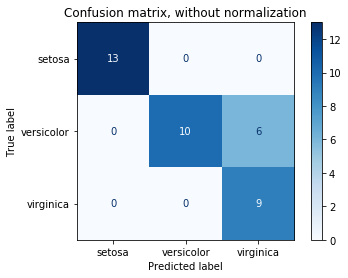

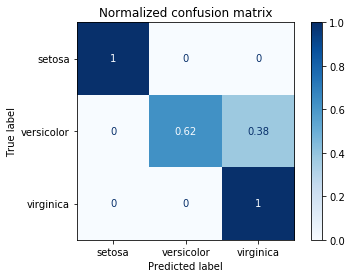

In [13]:



# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Visualize results

In [14]:
print("some very nice plots like the ones above")

some very nice plots like the ones above


# Discussion or whatever

- write down our insights or maybe do some further coding in the cell below

In [15]:
print("finally, done with this")

finally, done with this
